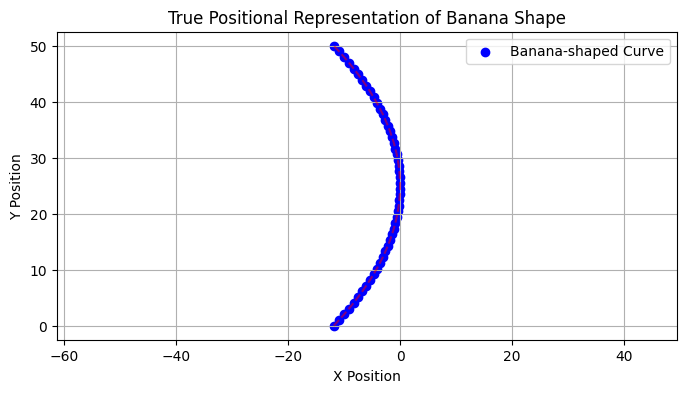

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.ops as ops

import matplotlib.pyplot as plt


class BananaDeformConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(BananaDeformConv, self).__init__()
        self.kernel_size = kernel_size
        self.offsets_layer = nn.Conv2d(in_channels, 2 * kernel_size**2, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2))
        self.deform_conv = ops.DeformConv2d(in_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2))

    def generate_banana_offsets(self, N, alfa, device):
        """ Generate 2D banana-shaped offsets for visualization. """
        t = torch.linspace(-3.14, 3.14, N, device=device)  # Parameter t, adjusted for better symmetry
        x_offsets = -alfa * t**2  # Quadratic function for x offsets
        return x_offsets
    
    def plot_offsets(self, N, alfa):
        plt.figure(figsize=(8, 4))
        
        x_offsets, y_offsets = self.generate_banana_offsets(N, alfa, 'cpu')
        
        plt.scatter(x_offsets, y_offsets, c='blue', label='Banana-shaped Curve')
        plt.plot(x_offsets, y_offsets, 'r--', alpha=0.5)  # Connecting line for visualization
        
        plt.title('True Positional Representation of Banana Shape')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # Ensure equal scaling on both axes
        plt.show()
        
    def forward(self, x):
        N = self.kernel_size
        generated_offsets = self.offsets_layer(x)  # Shape: [batch_size, 2 * kernel_size**2, height, width]
        batch_size, _, height, width = x.shape

        # Generate banana-shaped offsets
        x_offsets, y_offsets = self.generate_banana_offsets(N, 0.5, x.device)
        x_offsets = x_offsets.view(1, 1, N, 1).repeat(batch_size, generated_offsets.size(1) // 2, 1, N)
        y_offsets = y_offsets.view(1, 1, 1, N).repeat(batch_size, generated_offsets.size(1) // 2, N, 1)

        # banana shapes = the offsets
        generated_offsets[:, ::2, :, :] = x_offsets
        generated_offsets[:, 1::2, :, :] = y_offsets

        # Applying the deformable convolution using the modified offsets
        return self.deform_conv(x, generated_offsets)
    

model = BananaDeformConv(in_channels=3, out_channels=1, kernel_size=5)
model.plot_offsets(50, alfa=1.2)


Output shape: torch.Size([4, 20, 41, 100])
Offset shape: torch.Size([4, 120, 41, 100])


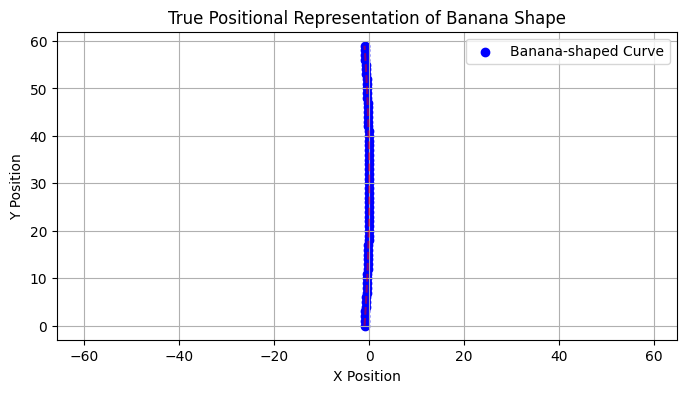

In [46]:
import torch 
from torchvision.ops import deform_conv2d

def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output dimensions (width, height) of a convolution operation.
    
    Parameters:
    - input_size (tuple): The width and height of the input feature map (width, height).
    - kernel_size (int or tuple): The size of the convolution kernel for each dimension (width, height).
    - stride (int or tuple): The stride of the convolution operation for each dimension (width, height).
    - padding (int or tuple): The amount of padding applied to each side of the input for each dimension (width, height).

    Returns:
    - tuple: The width and height of the output feature map (width, height).
    """
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)  # Make kernel size a tuple if it's not
    if isinstance(stride, int):
        stride = (stride, stride)  # Make stride a tuple if it's not
    if isinstance(padding, int):
        padding = (padding, padding)  # Make padding a tuple if it's not

    output_width = (input_size[0] - kernel_size[0] + 2 * padding[0]) // stride[0] + 1
    output_height = (input_size[1] - kernel_size[1] + 2 * padding[1]) // stride[1] + 1

    return (output_width, output_height)

input = torch.rand(4, 3, 100, 100)
bs, _, h, w = input.shape


kh, kw = 60, 1 # kernel
ph, pw = 0, 0 # padding 
sh, sw = 1, 1 # stride

out_channels = 20
weight = torch.rand(out_channels, 3, kh, kw)
# offset and mask should have the same spatial size as the output
# of the convolution. In this case, for an input of 10, stride of 1
# and kernel size of 3, without padding, the output size is 8
shapes = calculate_conv_output_size(input_size=(h,w), kernel_size=(kh,kw), stride=(sh,sw), padding=(ph,pw))
# Offset and mask calculation
offset = torch.rand(bs, 2 * kh * kw, shapes[0], shapes[1])

# Apply a uniform shift (e.g., shift right by 2 pixels)
x_shift = 0 # will be modified later on
y_shift = 0 # y_shift always zero

def generate_banana_offsets(N, alfa, device):
    """ Generate 2D banana-shaped offsets for visualization. """
    t = torch.linspace(-3.14, 3.14, N, device=device)  # Parameter t, adjusted for better symmetry
    x_offsets = -alfa * t**2  # Quadratic function for x offsets
    return x_offsets


x_offsets = generate_banana_offsets(N=kh, alfa=0.1, device=input.device)

for i in range(kh):
    for j in range(kw):
        x_shift = x_offsets[i]
        offset[:, 2 * (i * kw + j), :, :] = x_shift  # x-direction shift
        offset[:, 2 * (i * kw + j) + 1, :, :] = y_shift  # y-direction shift

# Ensure offset is of the correct type and device as the input
offset = offset.to(input.dtype).to(input.device)

# An offset is like `[y0, x0, y1, x1, y2, x2, ..., y8, x8]`. REF: https://mmcv.readthedocs.io/en/latest/_modules/mmcv/ops/deform_conv.html

mask = torch.rand(bs, kh * kw, shapes[0], shapes[1])
out = deform_conv2d(input, offset, weight, mask=mask, padding=(ph,pw), stride=(sh,sw))

print('Output shape:', out.shape)
print('Offset shape:', offset.shape)

out.shape
# returns
# torch.Size([4, 5, 8, 8])

def plot_banana_shape_2d(x_offsets, y_offsets):
    plt.figure(figsize=(8, 4))
    plt.scatter(x_offsets, y_offsets, c='blue', label='Banana-shaped Curve')
    plt.plot(x_offsets, y_offsets, 'r--', alpha=0.5)  # Connecting line for visualization
    
    plt.title('True Positional Representation of Banana Shape')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes
    plt.show()
    

y_offsets = [n for n in range(len(x_offsets))]
plot_banana_shape_2d(x_offsets, y_offsets)

In [39]:
offset.shape

torch.Size([4, 12, 5, 10])

In [ ]:
# Test the revised class
input_tensor = torch.rand(1, 3, 100, 100)  # Example input tensor
model = BananaDeformConv(in_channels=3, out_channels=1, kernel_size=5)
out = model(input_tensor)


In [ ]:
model.plot_offsets(10, alfa=0.01)

# Define the Banana Shape Offsets

For the banana shape, let’s compute sinusoidal offsets:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_banana_offsets(N, alfa):
    """ Generate 2D banana-shaped offsets for visualization. """
    t = np.linspace(-np.pi, np.pi, N)  # Parameter t, adjusted for better symmetry
    x_offsets = - alfa * t**2  # Sine function for x offsets
    y_offsets = np.linspace(0,N, N)  # Adjusted cosine for y offsets to form a banana shape
    return x_offsets, y_offsets

def plot_banana_shape_2d(x_offsets, y_offsets):
    plt.figure(figsize=(8, 4))
    plt.scatter(x_offsets, y_offsets, c='blue', label='Banana-shaped Curve')
    plt.plot(x_offsets, y_offsets, 'r--', alpha=0.5)  # Connecting line for visualization
    
    plt.title('True Positional Representation of Banana Shape')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes
    plt.show()


x_offsets, y_offsets = generate_banana_offsets(100, 1)
plot_banana_shape_2d(x_offsets, y_offsets)


In [ ]:
x_offsets, y_offsets = generate_banana_offsets(20, 0.1+0.05)
plot_banana_shape_2d(x_offsets, y_offsets)